<a href="https://colab.research.google.com/github/michellemtf/NeuromatchProject/blob/main/passiveSession_multiNeuron_cyl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up environment and import packages**

#### Install necessary packages

In [ ]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# **# Load the session and experiment summary tables**

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.27MMB/s] 
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 6.89MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.33MMB/s] 


Load summary tables

In [4]:
behavior_session_table = cache.get_behavior_session_table()
ophys_session_table    = cache.get_ophys_session_table()
ophys_experiment_table = cache.get_ophys_experiment_table()
#ophys_experiment_table.head()
#ophys_experiment_table['mouse_id']

In [ ]:
# Dictionary with session types
##
#session_type = {'familiar_active': ['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3'],
#                'novel_active':    ['OPHYS_4', 'OPHYS_5', 'OPHYS_6'],
#                'familiar_pasive': ['OPHYS_2_images_A_passive'],
#                'novel_pasive':    ['OPHYS_5_images_A_passive','OPHYS_5_images_B_passive']} # note: I think "OPHYS_5_images_B_passive" is novel, but not sure

#cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

#print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)  
        

In [ ]:
session_type = {'familiar_active':  ['OPHYS_1_images_A', 'OPHYS_3_images_A', 'OPHYS_4_images_A', 'OPHYS_6_images_A'],
                'novel_active':     ['OPHYS_1_images_B', 'OPHYS_3_images_B', 'OPHYS_4_images_B', 'OPHYS_6_images_B'],
                'familiar_passive': ['OPHYS_2_images_A_passive','OPHYS_5_images_A_passive'],
                'novel_passive':    ['OPHYS_2_images_B_passive','OPHYS_5_images_B_passive']} # note: I think "OPHYS_5_images_B_passive" is novel, but not sure

cre_line_type = ['Sst-IRES-Cre', 'Vip-IRES-Cre', 'Slc17a7-IRES2-Cre']

print(f'*Ophys session types in the current dataset:*\n\n {ophys_session_table.session_type.unique()}',)             

In [6]:
#cyllll label active and pasive
# Active vs passive
ind_passive = (ophys_experiment_table.session_type.str.contains(session_type['familiar_passive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['familiar_passive'][1]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_passive'][0]) |
               ophys_experiment_table.session_type.str.contains(session_type['novel_passive'][1])) 
ind_passive[ind_passive==False] = 'active'
ind_passive[ind_passive==True]  = 'pasive'
ophys_experiment_table['behavior_condition'] = ind_passive

In [7]:
print(np.size(ind_passive))
print(ind_passive.unique())
print(np.sum(ind_passive == 'pasive'))
print(np.sum(ind_passive == 'active'))

1165
['active' 'pasive']
339
826


In [8]:
# Familiar vs novel
fam = session_type['familiar_passive'] + session_type['familiar_active'] #select the passive session

i_fam = pd.Series([False]*ophys_experiment_table.shape[0]) #shape, help find the dimensions of the array
for f in fam:
  i_fam = (i_fam | ophys_experiment_table.session_type.str.contains(f))
i_fam[i_fam==True]  = 'familiar'
i_fam[i_fam==False] = 'novel'  
ophys_experiment_table['experimental_condition'] = i_fam

In [9]:
#check the labels and condition numbers
print(ophys_experiment_table.experimental_condition.unique())
print(np.sum(ophys_experiment_table.experimental_condition == 'familiar'))
print(np.sum(ophys_experiment_table.experimental_condition == 'novel'))

['familiar' 'novel']
467
698


Find a container with familiar and novel sessions

In [10]:
# Containers-cyllllll -use the excitatory neuron here
i_fam = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar"')['ophys_container_id']
i_nov = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "novel"')['ophys_container_id']

# Which containers are in both conditions
unic_fam = i_fam.unique()
i_both = []
for i,row in enumerate(unic_fam):
  if (row == i_nov.values).any():
    i_both.append(i)
    
# Choose the first container with fam & nov conditions
id_contain = unic_fam[i_both[0]]

In [11]:
print(np.size(i_both))
print(id_contain)

15
991913064


Select the experiments of a specific container

In [12]:
#cyllll
exper_famil = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "familiar" and ophys_container_id == @id_contain')
exper_novel = ophys_experiment_table.query('cre_line == "Slc17a7-IRES2-Cre" and behavior_condition == "pasive" and experimental_condition == "novel" and ophys_container_id == @id_contain')

In [13]:
exper_famil

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id,behavior_condition,experimental_condition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,
994955433,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,491060,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,124.0,Slc17a7-IRES2-Cre,GCaMP6f,5.0,0,2.0,8,994869518,994880774,991913064,VisualBehaviorTask1B,175,VISp,2019-12-17 17:15:08.000000,OPHYS_5_images_A_passive,995011003,pasive,familiar


In [14]:
exper_novel

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id,behavior_condition,experimental_condition
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,,,
993863108,CAM2P.3,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,491060,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",M,118.0,Slc17a7-IRES2-Cre,GCaMP6f,2.0,0,15.0,4,993669512,993706715,991913064,VisualBehaviorTask1B,175,VISp,2019-12-11 16:38:44.000000,OPHYS_2_images_B_passive,993916179,pasive,novel


## **Load one example session**

In [15]:
# Ophys experimental ID (choose the first experiment of familiar and novel conditions)
ophys_experiment_id_fam = exper_famil.index[0] #we actually only have one experiment
ophys_experiment_id_nov = exper_novel.index[0]

# Download particular ophys experiments
fam_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_fam)
nov_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id_nov)

behavior_ophys_experiment_994955433.nwb: 100%|██████████| 1.63G/1.63G [00:57<00:00, 28.2MMB/s]
behavior_ophys_experiment_993863108.nwb: 100%|██████████| 1.62G/1.62G [00:54<00:00, 29.7MMB/s]


Structure the data

In [16]:
metadata_keys = [
    'ophys_experiment_id',
    'ophys_session_id',
    'targeted_structure',
    'imaging_depth',
    'equipment_name',
    'cre_line',
    'mouse_id',
    'sex',
]

In [17]:
nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

In [18]:
#crush everytime
fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)

In [ ]:
#don't run this cell, it will crush
#fam_experiment_neural_data = ophys.build_tidy_cell_df(fam_experiment)
#nov_experiment_neural_data = ophys.build_tidy_cell_df(nov_experiment)

## **Examine Cell IDs**

In [22]:
#cyllllll
cell_ids_fam = fam_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for fam'.format(len(cell_ids_fam)))
print('cell ids are: {}'.format(cell_ids_fam))

cell_ids_nov = nov_experiment_neural_data['cell_specimen_id'].unique()
print('there are {} unique cells for nov'.format(len(cell_ids_nov)))
print('cell ids are: {}'.format(cell_ids_nov))

# Choose only one neuron ID
cell_id_fam = cell_ids_fam[0:2]
cell_id_nov = cell_ids_nov[0:2]

there are 280 unique cells for fam
cell ids are: [1086609591, 1086551376, 1086551633, 1086617450, 1086652573, ..., 1086561212, 1086611853, 1086611937, 1086604004, 1086601966]
Length: 280
Categories (280, int64): [1086609591, 1086551376, 1086551633, 1086617450, ..., 1086611853, 1086611937,
                          1086604004, 1086601966]
there are 261 unique cells for nov
cell ids are: [1086551792, 1086643019, 1086590320, 1086628626, 1086629436, ..., 1086627720, 1086629140, 1086599425, 1086599717, 1086588486]
Length: 261
Categories (261, int64): [1086551792, 1086643019, 1086590320, 1086628626, ..., 1086629140, 1086599425,
                          1086599717, 1086588486]


In [24]:
#cyllll
fam_stimulus_table = fam_experiment.stimulus_presentations
nov_stimulus_table = nov_experiment.stimulus_presentations

In [26]:
ETR_NOV = np.zeros([4253, 2]) #pick 2 neuron first
i = 0
for temp_cell_id in cell_id_nov:
  etr_nov = mindscope_utilities.event_triggered_response(
  data = nov_experiment_neural_data.query('cell_specimen_id == @temp_cell_id'),
  t = 'timestamps',
  y = 'dff',
  event_times = nov_stimulus_table.query('is_change == False and omitted == False')['start_time'], #no change images
  t_before=0,
  t_after=0.5,
  output_sampling_rate = 1,
  )
  #print(np.size(etr_nov.dff, 0))
  ETR_NOV[:,i] = etr_nov.dff
  i = i+1

4253
4253


In [28]:
#for cell_idssss in cell_id_nov:
ETR_FAM = np.zeros([4258, 2]) #pick 2 neuron first
i = 0
for temp_cell_id in cell_id_fam:
  etr_fam = mindscope_utilities.event_triggered_response(
  data = fam_experiment_neural_data.query('cell_specimen_id == @temp_cell_id'),
  t = 'timestamps',
  y = 'dff',
  event_times = fam_stimulus_table.query('is_change == False and omitted == False')['start_time'], #no change images
  t_before=0,
  t_after=0.5,
  output_sampling_rate = 1,
  )
  print(np.size(etr_fam.dff, 0))
  ETR_FAM[:,i] = etr_fam.dff
  i = i+1

4258
4258


In [ ]:
#for cell_id in cell_id_fam:
#etr_nov = mindscope_utilities.event_triggered_response(
#data = nov_experiment_neural_data.query('cell_specimen_id == @cell_id_nov'),
#t = 'timestamps',
#y = 'dff',
#event_times = nov_stimulus_table.query('is_change == False')['start_time'], #no change images
#t_before=0,
#t_after=0.5,
#output_sampling_rate = 1,
#)

In [29]:
print(np.size(etr_nov, 0))
print(np.size(etr_nov, 1))
etr_nov.head()

4253
4


,time,dff,event_number,event_time
0,0.0,-0.059167,0,307.52099
1,0.0,0.066646,1,308.27160
2,0.0,-0.045257,2,309.02222
3,0.0,-0.024693,3,309.77311
4,0.0,-0.001727,4,311.27405


(array([ 0.13186039,  1.22190625,  3.56023043,  8.08743703, 11.1378073 ,
         8.20171603,  3.73604428,  1.13399932,  0.20218593,  0.01758138]),
 array([-0.12729062, -0.10057463, -0.07385864, -0.04714265, -0.02042666,
         0.00628933,  0.03300532,  0.05972131,  0.08643729,  0.11315328,
         0.13986927]),
 <a list of 10 Patch objects>)

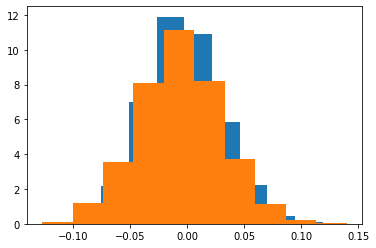

In [30]:
plt.hist(etr_nov.dff, density = True)
plt.hist(etr_fam.dff, density = True)